# Parsl Speed Comparison

This notebook performs two cosmic ray flux analyses that use the same raw data and same data transformation workflow to create a cosmic ray flux plot from raw data.

The first analysis uses traditional sequential, pure-Python calls to the relevant data transformation scripts.  The second uses Parsl to parallelize the dataflow.

## Pure Python

### Define parameters

In [1]:
# For WireDelay
thresholdAll = ('files/6119.2016.0104.1.thresh', 'files/6203.2016.0104.1.thresh')
wireDelayData = ('pp.6119.2016.0104.1.wd', 'pp.6203.2016.0104.1.wd')
geoDir = './geo'
detectors = ('6119', '6203')
firmwares = ('1.12', '1.12')

# For Combine
combineOut = 'pp.combineOut'

# For SingleChannel
singlechannel_channel = '1'
singleChannelOut = 'pp.singleChannelOut'

# For Sort
sort_sortKey1 = '2'
sort_sortKey2 = '3'
sortOut = 'pp.sortOut'

# For Flux
binWidth = '600'
geoFiles = ['geo/6119/6119.geo', 'geo/6203/6203.geo']
fluxOut = 'pp.fluxOut'

### Workflow

In [2]:
ppStart = !date +%s%N

for i in range(len(thresholdAll)):
    !{'perl ./perl/WireDelay.pl %s %s %s %s %s' %(thresholdAll[i], wireDelayData[i], geoDir, detectors[i], firmwares[i])}

!{'perl ./perl/Combine.pl ' + ' '.join(wireDelayData) + ' ' + combineOut}

!{'perl ./perl/SingleChannel.pl %s %s %s' % (combineOut, singleChannelOut, singlechannel_channel)}

!{'perl ./perl/Sort.pl %s %s %s %s' % (singleChannelOut, sortOut, sort_sortKey1, sort_sortKey2)}

!{'perl ./perl/Flux.pl %s %s %s %s' % (sortOut, fluxOut, binWidth, geoDir)}

ppStop = !date +%s%N
ppTime = int(ppStop[0]) - int(ppStart[0])
print("Pure Python execution time: " + str(ppTime) + " ns")

Pure Python execution time: 3741010278 ns


## Parsl

### Import and configure

In [3]:
import parsl
from parsl.config import Config
from parsl.executors.threads import ThreadPoolExecutor
from parsl.app.app import bash_app,python_app
from parsl import File

config = Config(
    executors=[ThreadPoolExecutor()],
    lazy_errors=True
)
parsl.load(config)

### Define Apps

In [4]:
# For data processing:
@bash_app
def WireDelay(threshIn='', outputs=[], geoDir='', daqId='', fw='', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/WireDelay.pl %s %s %s %s %s' %(threshIn, outputs[0], geoDir, daqId, fw)

@bash_app
def Combine(inputs=[], outputs=[], stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Combine.pl ' + ' '.join(inputs) + ' ' + str(outputs[0])

@bash_app
def SingleChannel(inputs=[], outputs=[], channel='1'):
    return 'perl ./perl/SingleChannel.pl %s %s %s' % (inputs[0], outputs[0], channel)
    
@bash_app
def Sort(inputs=[], outputs=[], key1='1', key2='1', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Sort.pl %s %s %s %s' % (inputs[0], outputs[0], key1, key2)

@bash_app
def Flux(inputs=[], outputs=[], binWidth='600', geoDir='geo/', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Flux.pl %s %s %s %s' % (inputs[0], outputs[0], binWidth, geoDir)

### Define parameters

In [5]:
# For WireDelay
thresholdAll = ('files/6119.2016.0104.1.thresh', 'files/6203.2016.0104.1.thresh')
wireDelayData = ('par.6119.2016.0104.1.wd', 'par.6203.2016.0104.1.wd')
geoDir = './geo'
detectors = ('6119', '6203')
firmwares = ('1.12', '1.12')

# For Combine
combineOut = 'par.combineOut'

# For SingleChannel
singlechannel_channel = '1'
singleChannelOut = 'par.singleChannelOut'

# For Sort
sort_sortKey1 = '2'
sort_sortKey2 = '3'
sortOut = 'par.sortOut'

# For Flux
binWidth = '600'
geoFiles = ['geo/6119/6119.geo', 'geo/6203/6203.geo']
fluxOut = 'par.fluxOut'

### Workflow

In [6]:
parStart = !date +%s%N

WireDelay_futures = []
for i in range(len(thresholdAll)):
        WireDelay_futures.append(WireDelay(threshIn=thresholdAll[i], outputs=[wireDelayData[i]], 
                                           geoDir=geoDir, daqId=detectors[i], fw=firmwares[i]))
        
WireDelay_outputs = [i.outputs[0] for i in WireDelay_futures]

Combine_future = Combine(inputs=WireDelay_outputs, outputs=[combineOut])

SingleChannel_future = SingleChannel(inputs=Combine_future.outputs, outputs=[singleChannelOut], 
                                     channel=singlechannel_channel)

Sort_future = Sort(inputs=SingleChannel_future.outputs, outputs=[sortOut], 
                   key1=sort_sortKey1, key2=sort_sortKey2)

Flux_future = Flux(inputs=Sort_future.outputs, outputs=[fluxOut], binWidth=binWidth, geoDir=geoDir)

x = Flux_future.result()

print("Call to Flux completed with exit code:", x)

parStop = !date +%s%N
parTime = int(parStop[0]) - int(parStart[0])
print("Pure Python execution time: " + str(ppTime) + " ns")
print("Parsl execution time: " + str(parTime) + " ns")
print("Parsl completes " + str((ppTime - parTime)*100/ppTime) + "% faster")

Call to Flux completed with exit code: 0
Pure Python execution time: 3741010278 ns
Parsl execution time: 2051795871 ns
Parsl completes 45.15396327387476% faster


### Plot

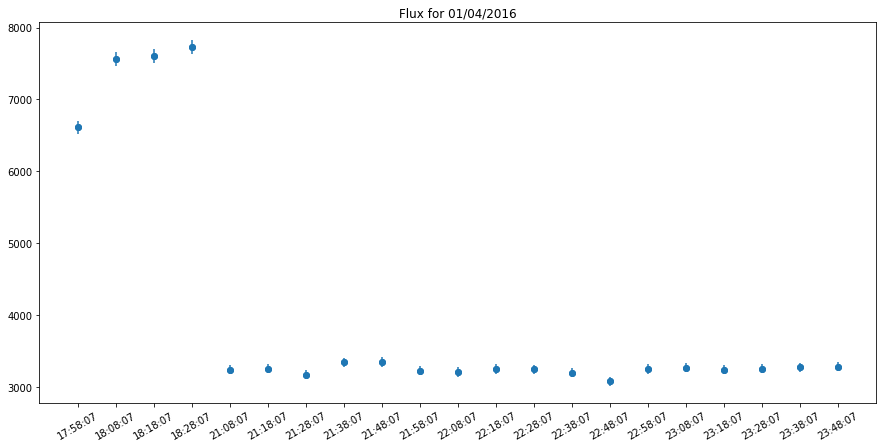

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

with open("par.fluxOut") as flux:
    # 'lines' will be a list having each line of 'fluxOut' as an element
    lines = flux.readlines()
    # Remove the first two lines, which are comments
    lines = lines[2:]
    # Get the date
    date=str(lines[0].split()[0])
    
    # Split each line into x, y, and uncertainty arrays:
    x = [(line.split()[1]) for line in lines]
    y = [float(line.split()[2]) for line in lines]
    dy = [float(line.split()[3]) for line in lines]

#print(x)
#print(y)
#print(len(y))

# Make the output plot bigger:
#scale=15
#plt.rcParams["figure.figsize"]=[scale,scale]
plt.rcParams["figure.figsize"]=[15,7]

# Slant tick-labels on x-axis for readability
plt.xticks(rotation=30)

# Add a title
plt.title("Flux for " + date)

plt.scatter(x,y)

# Add error bars
#   Amplify error bars just to see if they're really there:
#   dy = [20*i for i in dy]
plt.errorbar(x,y,yerr=dy,linestyle="None",fmt='o')
plt.show()